#Application: Dow Industrial Matching

In [15]:
import Quandl as q
import pandas as pd
import numpy as np
import json
import scipy.sparse as sp
import whoosh_ as who
import matplotlib.pyplot as plt
import os
import random
import seaborn
%matplotlib inline

## Creating feature vectors from Dow Industrial data


This application is carried out with data accessed through Quandl, an extremely conveient source that publishes in many useful formats. For us, pandas.

The data comes in the percentage diffrence in closing value from one day to the next, another task we are not burnded with. This allows us to use the entire history of the Dow, not merely a subsection due to the large increase in the Dow's value. 

In [8]:
dow_ = q.get("BCB/UDJIAD1", authtoken="e4SU4p5zDL4UPLuBY7Ty", transformation="rdiff")
dow = dow_ # create secondary set 
dow['Value'] = dow_['Value']*100 # scale by 100 to get %

To create feature vectors, the standard method in forecasting is to take the values 'n' days before the day in question. As we would not like to get into the details required to make nearest neighbours decent at forecasting, but more simply match similar days in the Dow to demonstrate our method, our vectors will be centred on the day in question. That is, a 20-dimensional vector will be the 10 days on either side of the day in question. 

In [9]:
def gen_mid_vecs(dow, d):
    '''d is the number of days on each side of the query date
    '''
    vecs = []
    for i in range(d, len(dow)):
        vec1 = list(dow['Value'][i-d:i])
        vec2 = list(dow['Value'][i+1:i+d+1])
        vec = vec1 + vec2
        if len(vec)==d*2:
            vecs.append(vec)
    return np.array(vecs)

def true_score(query_day, match_day, vectors, dates):
    query_index = int(np.where(np.array(dates)==query_day)[0])
    query_vec = vectors[query_index]/np.linalg.norm(vectors[query_index])
    
    match_index = int(np.where(np.array(dates)==match_day)[0])
    match_vec = vectors[match_index]/np.linalg.norm(vectors[match_index])
    return np.dot(query_vec, match_vec)

def create_json(keys, data, directory_filename):
    histogram_archive = {}
    for k,h in zip(keys,data):
        h_as_list = tuple(h)
        histogram_archive[k] = h_as_list
    
    with open(directory_filename, 'w') as outfile:
        json.dump((histogram_archive), outfile,indent = 4)
    return

As in our image application, we will create .json files to store data in an effort to more quickly perform experiments.

In [10]:
# must create json so that vecs line up with the right date
d = 5
m = 30000 #m must be a multiple of d for structured transform
vectors = gen_mid_vecs(dow,d)
dates = [str(x) for x in dow.index.date[d:len(dow)-d]]

json_file = '/home/treimer/var/data/econ_indexes/matching_{}_{}/{}.json'.format(d,m,d)
index_dir = '/home/treimer/var/data/econ_indexes/matching_{}_{}'.format(d, m)

if not os.path.exists(index_dir):
    os.makedirs(index_dir)
    
create_json(dates, vectors, json_file)

params = {'d': d*2, 'm': m, 'r': 0.2, 'r2': 0.2,}

#histo_file, params, transformer, out_directory
who.index_json(json_file, params, 'gaussian', index_dir)

## Data Description

In the paper, to demonstrate the difference in the two datasets used, dow and image data, we decompose a sample of the dataset.

This is performed with the Singular Value Decompostion. We then take the first two unitary vectors and project our data onto them, providing us with an (x,y) for each vector. 

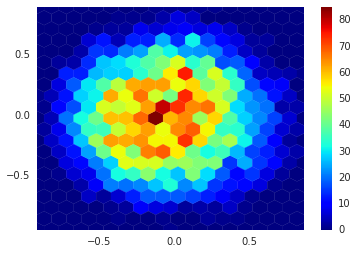

In [12]:
#vectors = gen_mid_vecs(dow,d)
norms = np.linalg.norm(vectors, ord=None, axis=1)
vectors = np.array(vectors/norms[:, np.newaxis])

u, s, v = np.linalg.svd(vectors.transpose())

u_ = u[:,0:2]
projections = []

for vec in vectors[0:7000]:
    projections.append(np.dot(vec,u_))
    
projections = np.array(projections)
x = projections[:,0]
y = projections[:,1]

plt.hexbin(x, y, gridsize = 18, cmap = 'jet' )
plt.colorbar()
plt.show()

## Nearest Neighbours

Below is a table displaying the most tremendous days in the Dow Industrial. On the left we have the biggest booms and on the right the largest busts. 

We use these days as a reference point to see if similar patterns exist in other days of major change in the Dow. 

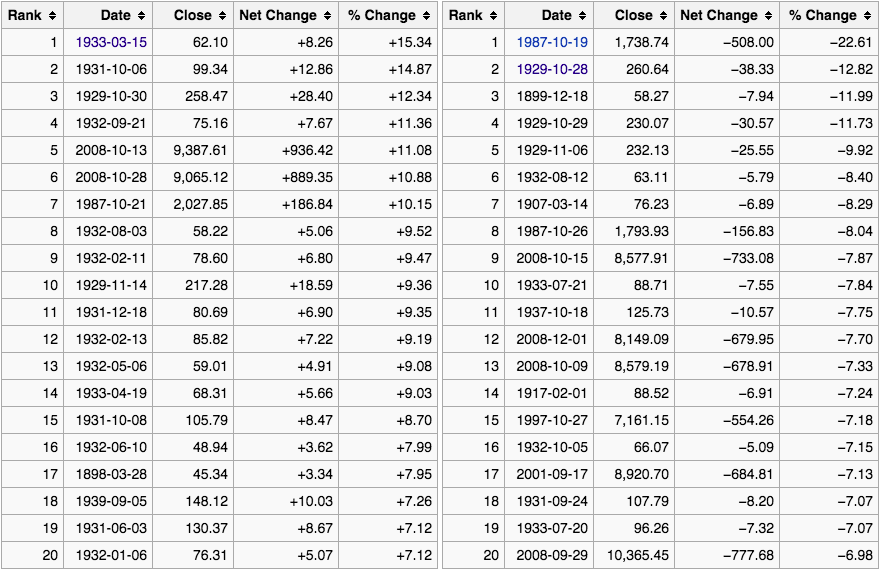

In [278]:
from IPython.display import Image
Image(filename='/home/treimer/var/data/econ_indexes/dow_changes.png')

In [19]:
def plot_vecs(matches, vectors, dates, d):
    plt.rc('text', usetex=False)
    x_labels = list([r'd{}'.format(i-d) for i in range(d)] + ['d+{}'.format(i+1) for i in range(d)])
    axes = tuple(['ax{}'.format(i) for i in range(0, len(matches)+1)])
    out = fig, axes = plt.subplots(len(matches)+1, 1, figsize=(4, 8), sharex=True)
    
    axes[0].patch.set_facecolor('white')
    
    the_table = axes[0].table(cellText = [[r'Date', r'Forecast', r'True Score']], loc = 'left')
    table_props = the_table.properties()
    table_cells = table_props['child_artists']
    for cell in table_cells: cell.set_height(1.0)
    
    axes = axes[1:]
    
    counter = 0
    for ax_, match in zip(axes, matches):
        
        match_index = int(np.where(np.array(dates)==match)[0])
        match_vec = vectors[match_index]/np.linalg.norm(vectors[match_index]) #normalizing
        
        x = np.array(x_labels)
        sns.barplot(x, match_vec, hline=1.0, ax=ax_, x_order = x) # hline is placement of line: y = hline
        if counter == 0:
            palette = seaborn.color_palette("deep")
            sns.barplot(x, match_vec, hline=1.0, ax=ax_, x_order = x, color = palette[1])
        
        forecast = round(dow['Value'].loc[match],3)
        true_score_ =  round(true_score(day, match, vectors, dates), 3)
        
        the_table = ax_.table(cellText=[[r'{}'.format(match), r'{}'.format(forecast), 
                                         r'{}'.format(true_score_)]], loc='left') 
        if counter == 0:
            the_table = ax_.table(cellText=[[r'{}'.format(match), r'{}'.format(forecast), 
                                         r'query']], loc='left') 
            counter += 1
        
        table_props = the_table.properties()
        table_cells = table_props['child_artists']
        for cell in table_cells: cell.set_height(1.0) # play with this value to change cell height
    
        
        counter +=1
    plt.setp(fig.axes, yticks=[])
    plt.tight_layout(h_pad=0.05)
    return fig, axes

Below is a example of the results our nearest neighbours method would return. 

As can be seen by the vectors bar graphs, similar matches have been returned. However, using these similar vectors to make a forecast about the Dow would require an upgrade on the nearest neighbour method, as can be found in the economic literature. 

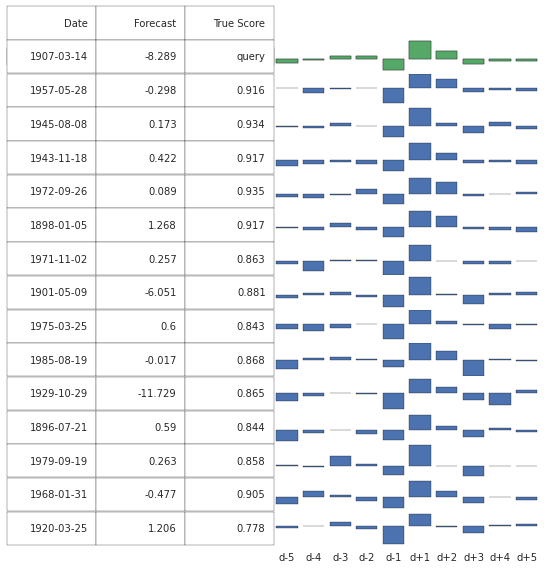

In [20]:
#day = '2008-10-28'
day = '1907-03-14'
matches, _ = who.search(day, json_file, params, 'gaussian', index_dir, 15)
plot_vecs(matches, vectors, dates, d)
plt.show()

## Precision vs. Recall
A standard of the literature, we use our nearest neighbours approximation algorithm to calculate the precision and recall scores for our image data. 

Precision and recall are defined as follows:

$$
       precision = \frac{retrieved \cap relevant}{retrieved} $$
        
$$
       recall = \frac{retrieved \cap relevant}{relevant} $$
        

An image is retrieved if our given score is getter than some threshold T. An image is relevant if its true score is greater than some desired threshold, $ \lambda $.


In [22]:
def precision_recall(scores, T, true_scores, lambda_):
    retrieved = 0
    relevant = 0
    retrieved_and_relevant = 0
    
    for i in range(0, len(scores)):
        if scores[i] > T:
            retrieved += 1
            retrieved_ = True    
        else:
            retrieved_ = False
        
        if true_scores[i] > lambda_:
            relevant += 1
            relevant_ = True
        else:
            relevant_ = False
        
        if retrieved_ == True and relevant_ == True:
            retrieved_and_relevant += 1        
    try:
        precision = retrieved_and_relevant/float(retrieved)    
    except:
        precision = 0
    
    try:
        recall = retrieved_and_relevant/float(relevant)
    except:
        recall = 0
        
    return precision, recall

def ref_pts(recall, precision, t_range):
    for i,k in enumerate(zip(recall, precision)):
        if recall[i] == 1.0:
            pt1 = [k, t_range[i]]
        if precision[i] == 1.0:
            pt2 = [k, t_range[i]]
            break
    return pt1, pt2

def index_corpus(X, A, h):
    ''' index the corpus documents, producing a Boolean matrix                             
    A is the nb_dimensions x m random projection matrix'''
    Y = np.dot(X, A)
    Ybool = sp.csr_matrix(np.where(Y>h, 1, 0))                                                
    Ybool.eliminate_zeros()                                                                       
    return Ybool 

def generate_projection_matrix(document_dimension, m, random_seed=None):
    if random_seed: np.random.seed(random_seed)                                                         
    return np.random.randn(document_dimension, m)

In [ ]:
vectors = gen_mid_vecs(dow,d)
norms = np.linalg.norm(vectors, ord=None, axis=1)
vectors = np.array(vectors/norms[:, np.newaxis])

In [ ]:
X = vectors[0:8000,:]
lambda_ = 0.8
m = 30000
r = 0.2
h = np.sqrt(2*r*np.log(m))
nb_iter = 300
step = 0.01
t_range = np.arange(0.2, .9, step)

A = generate_projection_matrix(X.shape[1], m)
I = index_corpus(X,A,h)

precision, recall, precision_std, recall_std = [], [], [], []

for T in t_range:
    iter_precision, iter_recall = [], []
    
    for i in range(0,nb_iter):
        
        q_index = random.choice(range(X.shape[0]))

        scores_list = I.dot(I[q_index].transpose()).todense()
        scores_list = scores_list/float(max(scores_list))

        true_scores = np.dot(X, X[q_index])

        prec_, rec_ = precision_recall(scores_list, T, true_scores, lambda_)

        iter_precision.append(prec_)
        iter_recall.append(rec_)
        
    
    precision.append(np.mean(iter_precision))
    recall.append(np.mean(iter_recall))
    precision_std.append(np.std(iter_precision))
    recall_std.append(np.std(iter_recall))

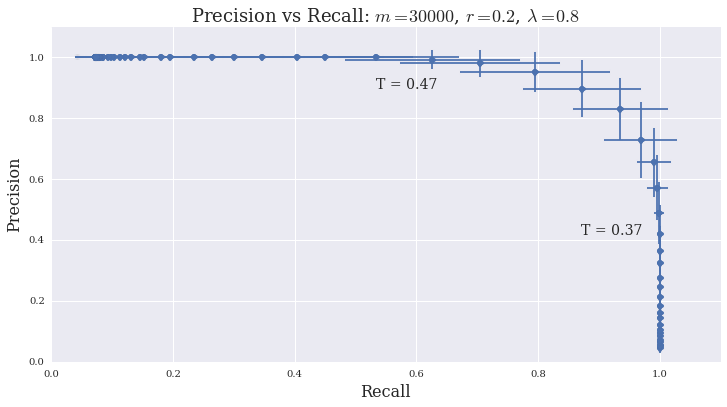

In [27]:
import seaborn as sns 
sns.set_style('darkgrid')
plt.rc('font', family='serif', size=16)
fig,ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel(r'Recall', fontsize=16)
ax.set_ylabel(r'Precision', fontsize=16)
ax.set_title(r'Precision vs Recall: $m = {}$, $r = {}$, $\lambda = {}$'.format(m, r, lambda_), fontsize=18)
plt.errorbar(recall, precision, xerr = recall_std , yerr= precision_std, fmt='o')
plt.ylim(0, 1.1)
plt.xlim(0, 1.1)
pt1, pt2 = ref_pts(recall, precision, t_range)
plt.text(pt1[0][0]-0.13, pt1[0][1], r'T = {}'.format(pt1[1]), fontsize = 14)
plt.text(pt2[0][0], pt2[0][1]-0.1, r'T = {}'.format(pt2[1]), fontsize = 14)
ax.legend() 